[gradus](https://github.com/theokoles7/gradus/blob/main/README.md) / [documentation](../README.md) / [dataset-analyses](./README.md) / cifar-100-analysis

# CIFAR-100 Dataset Analysis

This notebook file analyzes the CIFAR-100 dataset to understand the image complexity properties it possesses and how they are distributed across the dataset samples.

## Load CIFAR-100 Dataset

In [1]:
"""# Load CIFAR100 dataset."""

from typing                 import List

from torchvision.datasets   import CIFAR100
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

# Define image transform.
transform:  Compose =   Compose([Resize(size = (32, 32)), ToTensor(), Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))])

# Initialize dataset splits.
train_set:  CIFAR100 =  CIFAR100(root = "data", train = True,  transform = transform, download = True)
test_set:   CIFAR100 =  CIFAR100(root = "data", train = False, transform = transform, download = True)

# Extract classes.
classes:    List[str] = train_set.classes

## Compute Image Complexity Metrics

In [9]:
"""# Compute image complexity metrics for CIFAR100 dataset."""

from json           import dump
from typing         import Dict

from tqdm           import tqdm

from gradus.metrics import *

# Initialize analysis mapping.
analysis:   Dict[int, Dict] =   {i: {} for i in range(len(train_set))}

# For each sample in the dataset...
for i in tqdm(range(len(train_set)), desc = "Analyzing CIFAR100 samples", unit = "sample"):

    # Get sample.
    sample = train_set[i]

    # Take note of the class of the sample.
    analysis[i]["class"] =                      classes[sample[1]]

    # Compute and store image complexity metrics.
    analysis[i]["color_variance"] =             color_variance(image =    sample[0])
    analysis[i]["compression_ratio"] =          compression_ratio(image = sample[0])
    analysis[i]["edge_density"] =               edge_density(image =      sample[0])
    rf, cf, of =                                spatial_frequency(image = sample[0])
    analysis[i]["wavelet_energy"] =             wavelet_energy(image =    sample[0]).total_energy
    analysis[i]["wavelet_entropy"] =            wavelet_entropy(image =   sample[0]).entropy
    
    # Unpack the tuple (RF, CF, OF).
    analysis[i]["spatial_frequency_row"] =      rf
    analysis[i]["spatial_frequency_column"] =   cf
    analysis[i]["spatial_frequency_overall"] =  of

Analyzing CIFAR100 samples: 100%|██████████| 50000/50000 [00:42<00:00, 1177.78sample/s]


## Plot Metric Distributions by Class

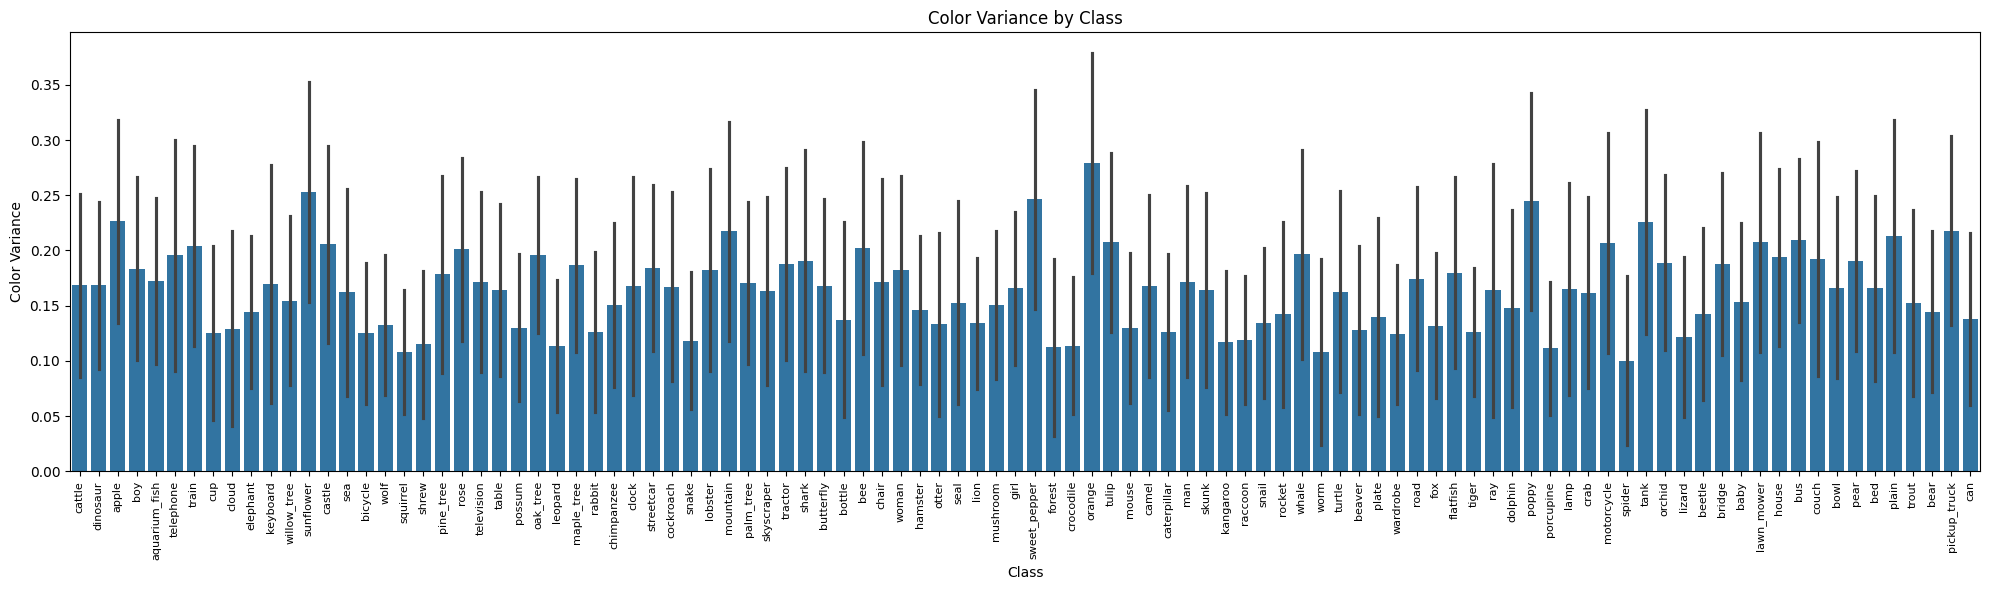

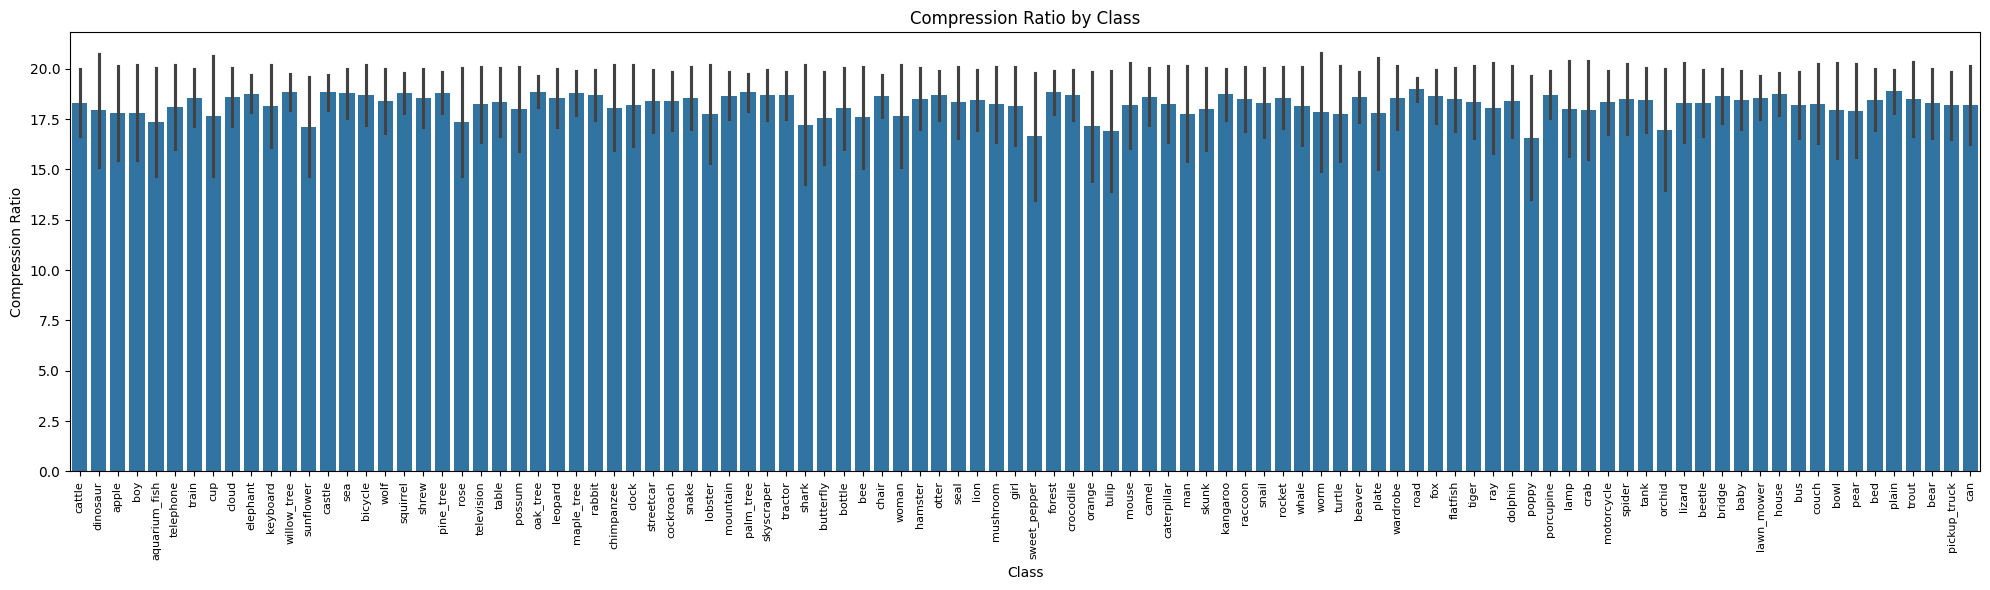

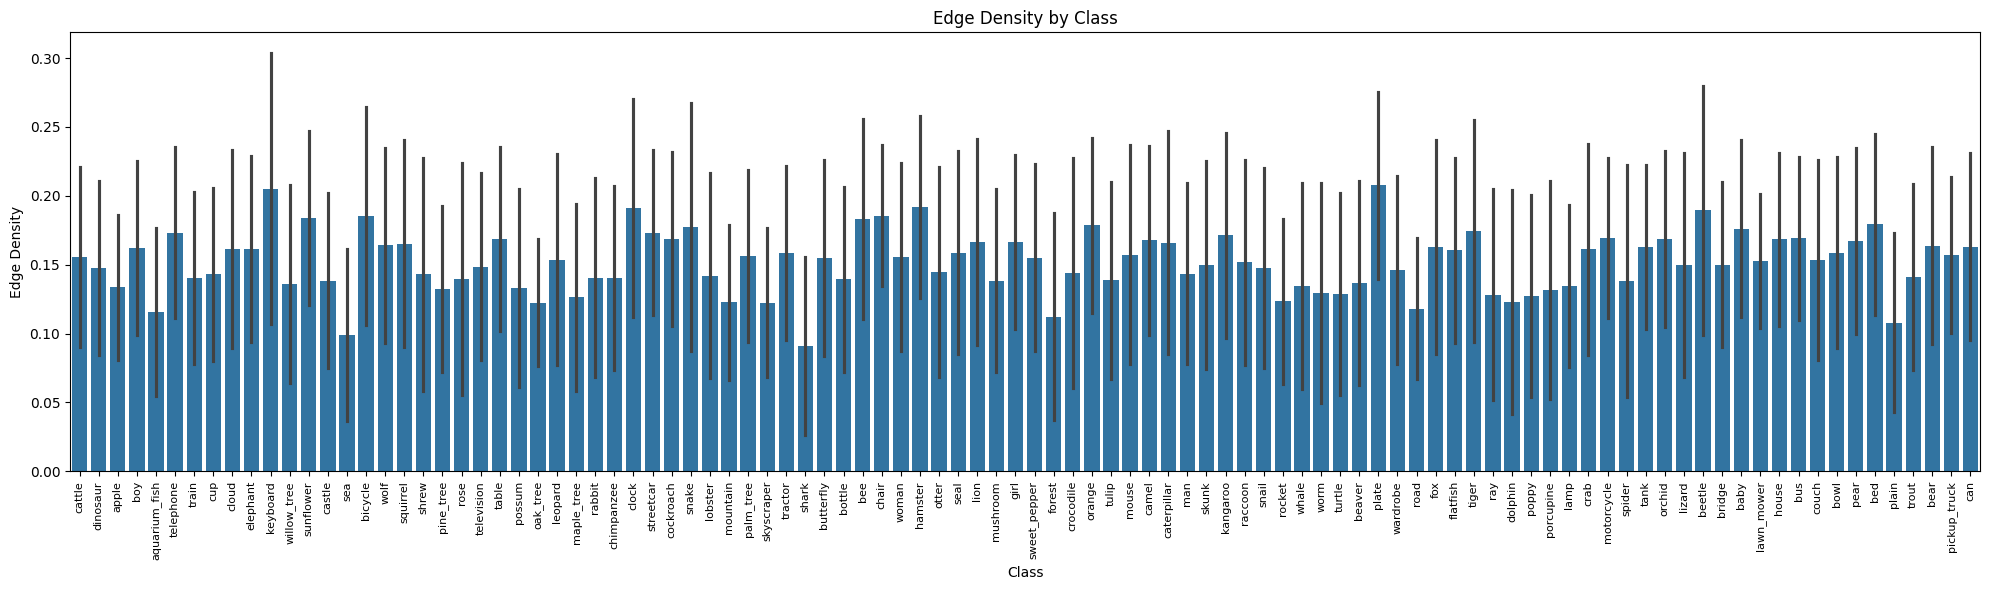

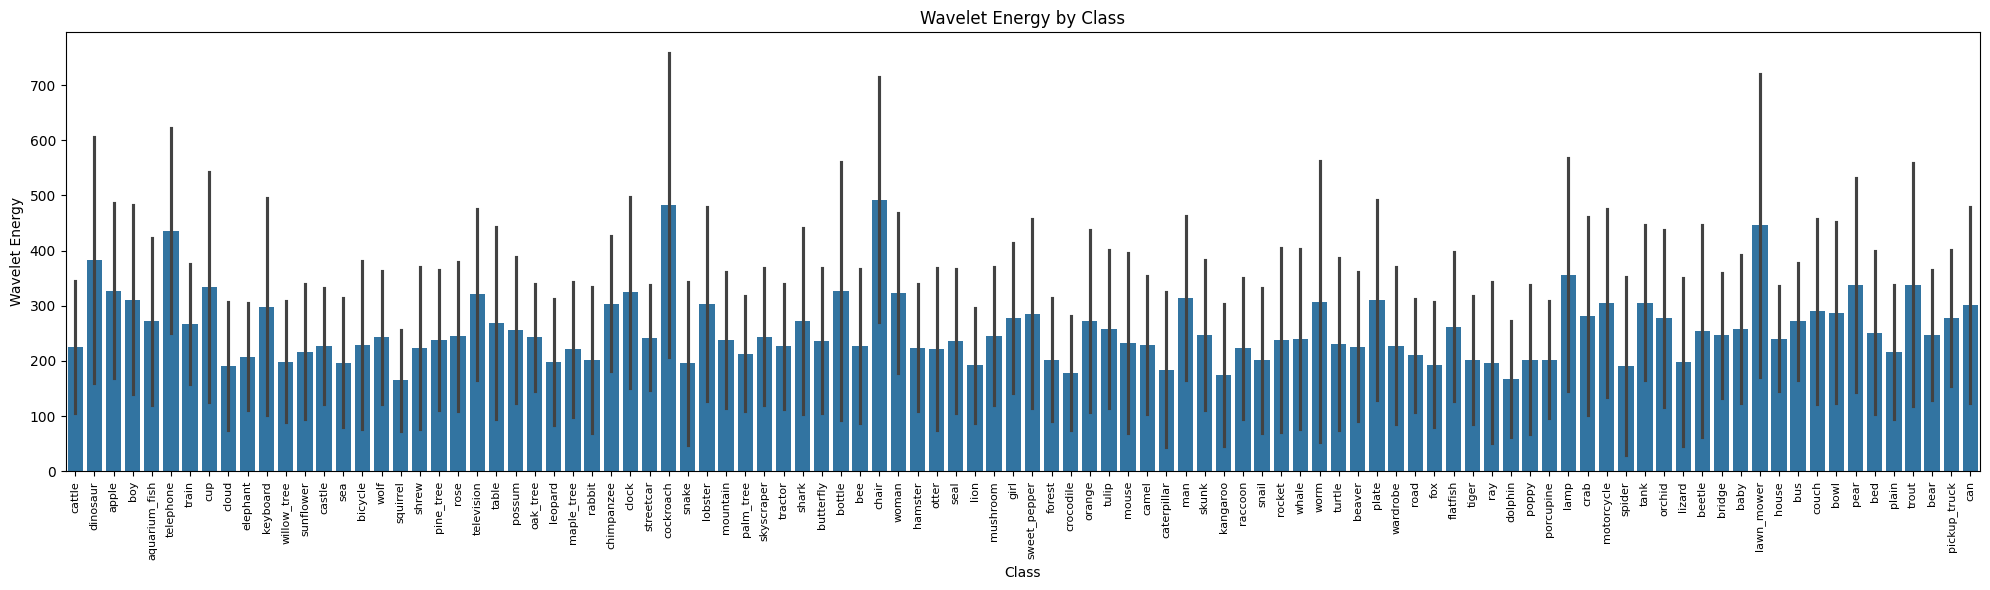

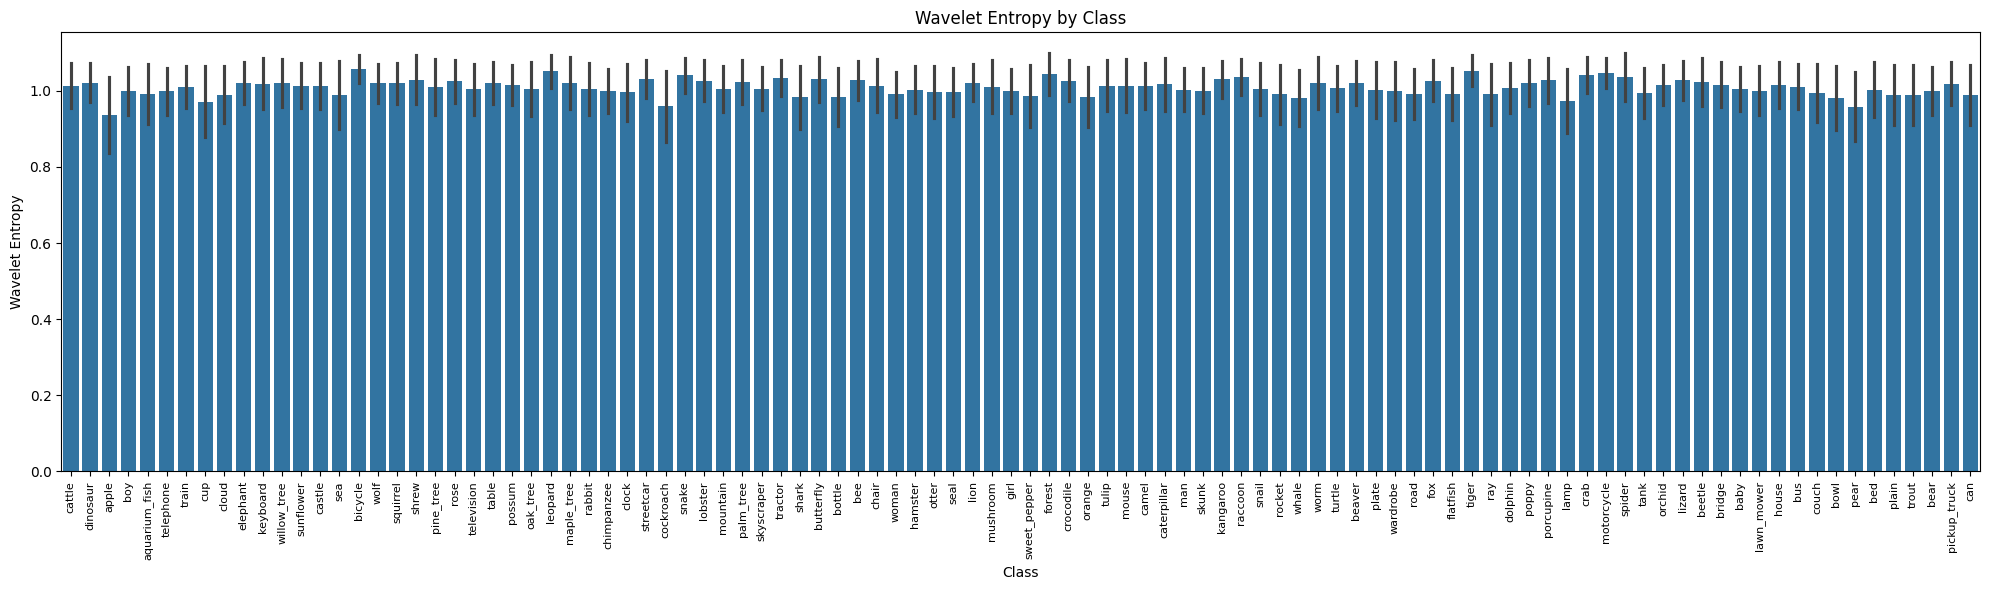

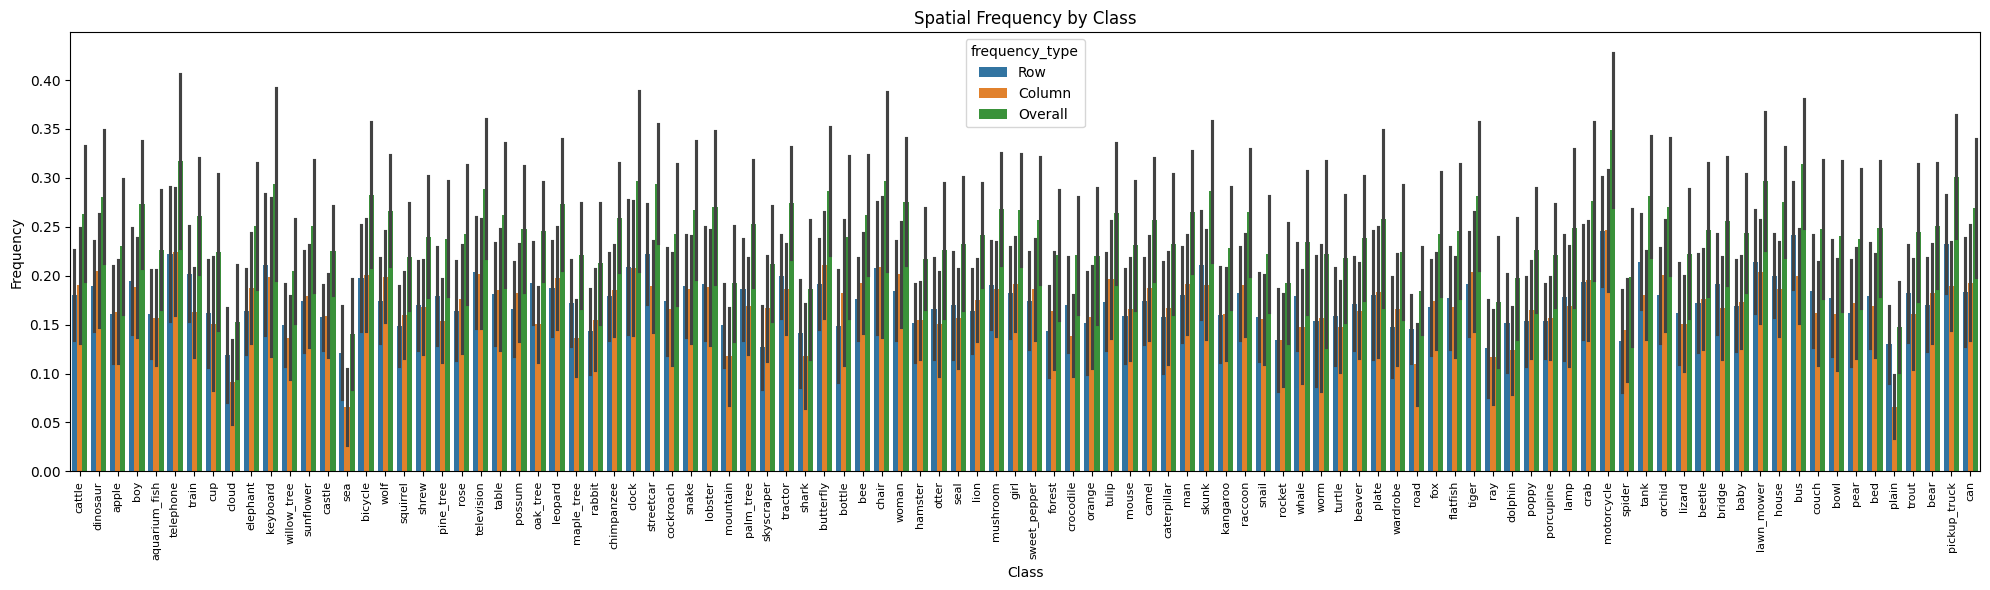

In [10]:
"""# Plot metric distributions by class."""

from typing             import List

from matplotlib.pyplot  import show, subplots, xticks
from pandas             import DataFrame, melt
from seaborn            import barplot

# Convert analysis to DataFrame.
df:         DataFrame = DataFrame.from_dict(analysis, orient = "index")

# Plot distributions of standard metrics by class.
metrics:    List[str] = ["color_variance", "compression_ratio", "edge_density", "wavelet_energy", "wavelet_entropy"]

# For each metric analyzed...
for metric in metrics:

    # Create a wide figure to accommodate all 100 classes.
    fig, ax = subplots(figsize = (20, 6))
    
    # Use barplot to show mean with error bars per class.
    barplot(x = "class", y = metric, data = df, ax = ax, errorbar = "sd")
    
    ax.set_title(f"{metric.replace('_', ' ').title()} by Class")
    ax.set_xlabel("Class")
    ax.set_ylabel(metric.replace('_', ' ').title())
    
    # Rotate x-axis labels for readability.
    xticks(rotation = 90, fontsize = 8)
    fig.tight_layout()
    show()

# Melt spatial frequency columns for grouped visualization.
df_melted: DataFrame =  melt(
                            df[["class"] + ["spatial_frequency_row", "spatial_frequency_column", "spatial_frequency_overall"]],
                            id_vars =       ["class"],
                            var_name =      "frequency_type",
                            value_name =    "value"
                        )

# Rename frequency types for better readability.
df_melted["frequency_type"] = df_melted["frequency_type"].str.replace("spatial_frequency_", "").str.title()

# Plot all spatial frequency components in one wider plot.
fig, ax = subplots(figsize = (20, 6))
barplot(x = "class", y = "value", hue = "frequency_type", data = df_melted, ax = ax, errorbar = "sd")
ax.set_title("Spatial Frequency by Class")
ax.set_xlabel("Class")
ax.set_ylabel("Frequency")
xticks(rotation = 90, fontsize = 8)
fig.tight_layout()
show()